In [82]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### dataframe dados escolares/esc_rmsp/relatórios

In [8]:
#abrindo os dados
dados_escolares = pd.read_csv('DadosEscolares1996-2015.csv', encoding = 'latin1')
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
rendimento = pd.read_csv('RendimentoEscolar2000-2015.csv', encoding = 'latin1')
nota = pd.read_csv('ENEM2015.csv')
#agrupando por escolas
rendimento = rendimento.groupby('CODMEC').mean()
dados_escolares = dados_escolares.groupby('CODMEC').mean()
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
#Apagando a classe desbalanceada
nota = nota[nota.Classificacao != 0]
#Alterando o nome da coluna de acordo com os outros dataframes
nota.rename(columns = {'CODIGO DA ENTIDADE':'CODMEC'}, inplace = True)
#Em todos Dataframes temos mais escolas do que o nosso target
dados_escolares = dados_escolares.reset_index()[dados_escolares.reset_index().CODMEC.isin(nota['CODMEC'])]
esc_rmsp = esc_rmsp.reset_index()[esc_rmsp.reset_index().CODESC.isin(nota['CODMEC'])]
esc_rmsp.rename(columns = {'CODESC': 'CODMEC'}, inplace = True)
rendimento = rendimento.reset_index()[rendimento.reset_index().CODMEC.isin(nota['CODMEC'])]
print("\tshapes com NaN's:")
print('dados_escolares: ', dados_escolares.shape)
print('esc_rmsp: ', esc_rmsp.shape)
print('rendimento: ', rendimento.shape)



#apgando valores nulos
#dados_escolares.drop(dados_escolares.columns[dados_escolares.isnull().mean() != 0], axis=1, inplace = True)
#esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isnull().mean() >= 0.15], axis=1, inplace = True)
#esc_rmsp.dropna(inplace = True, how = 'any')
#def t(x):
#    if x==0:
#        return None
#    else:
#        return x
#for c in rendimento.columns:
#    rendimento[c] = rendimento[c].apply(t)
#rendimento.drop(rendimento.columns[rendimento.isnull().mean() >= 0.15], axis=1, inplace = True)
#rendimento.dropna(inplace = True, how = 'any')

C:\Users\giova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6,8,11,17,18,19,20,111,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\giova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


	shapes com NaN's:
dados_escolares:  (692, 233)
esc_rmsp:  (1241, 126)
rendimento:  (504, 85)


## histograma da porcentagem de valores nulos das colunas

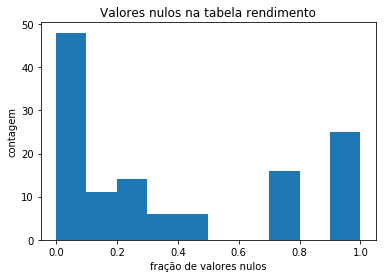

In [3]:
plt.hist(esc_rmsp.isna().mean().sort_values(ascending = False))
plt.title('Valores nulos na tabela rendimento')
plt.xlabel('fração de valores nulos')
plt.ylabel('contagem')
plt.show()

In [4]:
#dropando as colunas com mais de 60% de valores nulos
print('nº colunas anteriores: ', esc_rmsp.shape[1])
esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isna().mean() > 0.6], axis = 1, inplace = True)
print('nº colunas ', esc_rmsp.shape[1])

nº colunas anteriores:  126
nº colunas  85


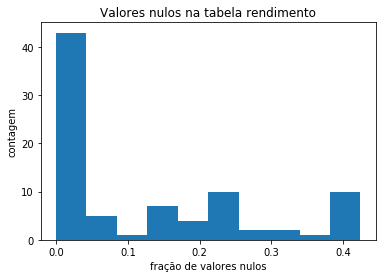

In [5]:
plt.hist(esc_rmsp.isna().mean().sort_values(ascending = False))
plt.title('Valores nulos na tabela rendimento')
plt.xlabel('fração de valores nulos')
plt.ylabel('contagem')
plt.show()

In [6]:
#dropando as colunas com mais de 40% de valores nulos
print('nº colunas anteriores: ', esc_rmsp.shape[1])
esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isna().mean() > 0.35], axis = 1, inplace = True)
print('nº colunas ', esc_rmsp.shape[1])

nº colunas anteriores:  85
nº colunas  74


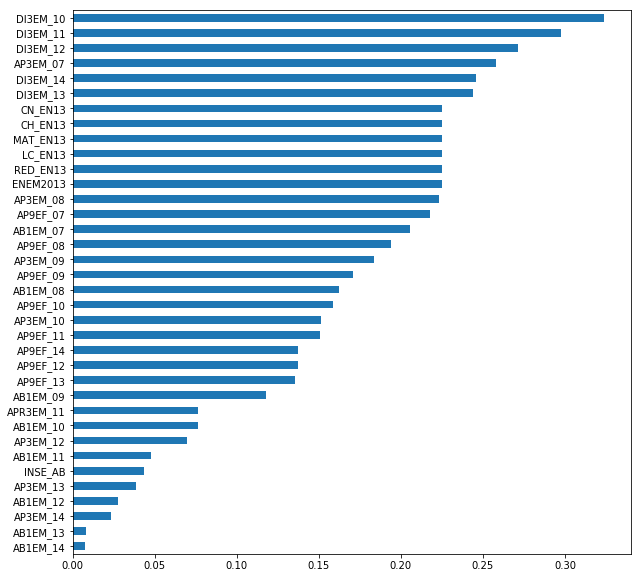

In [8]:
esc_rmsp.loc[:,esc_rmsp.isna().mean().sort_values(ascending = False) != 0].isna().mean().sort_values().plot(kind = "barh", figsize = (10,10))

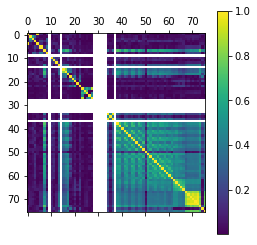

In [9]:
aux_df = pd.merge(esc_rmsp, nota, on = "CODMEC")
plt.matshow(aux_df.corr().abs())
plt.colorbar()
plt.show()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(aux_df.corr()[(aux_df.corr() > 0.5) & (aux_df.corr() != 1)].fillna(0).sum().sort_values(ascending = False))

COD_DEP                    12.952827
INSE_AB                    12.074565
AP9EF_09                   10.468953
AP3EM_07                    9.956906
AP9EF_07                    9.832236
AP9EF_08                    9.706573
AP3EM_09                    9.700445
APR3EM_11                   9.667868
AP9EF_10                    9.605163
AP3EM_12                    9.439394
AP9EF_13                    9.162262
AP9EF_12                    9.056377
AP3EM_08                    9.055729
AP3EM_13                    8.762973
AP3EM_10                    7.930621
AP9EF_14                    7.443463
ENEM2013                    6.854074
CN_EN13                     6.696399
MAT_EN13                    6.684492
AP3EM_14                    6.176778
CH_EN13                     6.172542
LC_EN13                     6.040358
RED_EN13                    5.599939
Classificacao               5.233907
REG_IN_PE                   4.701103
AB1EM_11                    4.165649
AB1EM_10                    3.515583
D

In [12]:
#colunas sobre o enem
esc_rmsp.drop(['CN_EN13', 'CH_EN13', 'MAT_EN13', 'LC_EN13', 'RED_EN13'], axis = 1, inplace = True)
#sobre a cidade
esc_rmsp.drop(['CODDIST'], axis = 1, inplace = True)
#crianças especiais
esc_rmsp.drop(['ESP_IN_CR', 'ESP_IN_PE', 'ESP_FU_9A'], axis = 1, inplace = True)
#EJA
esc_rmsp.drop(['EJA_MED'], axis =1, inplace = True)
#ensino regular
esc_rmsp.drop(['REG_IN_CR'], axis =1, inplace = True)

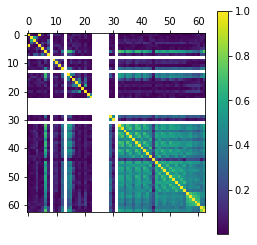

In [13]:
plt.matshow(esc_rmsp.corr().abs())
plt.colorbar()

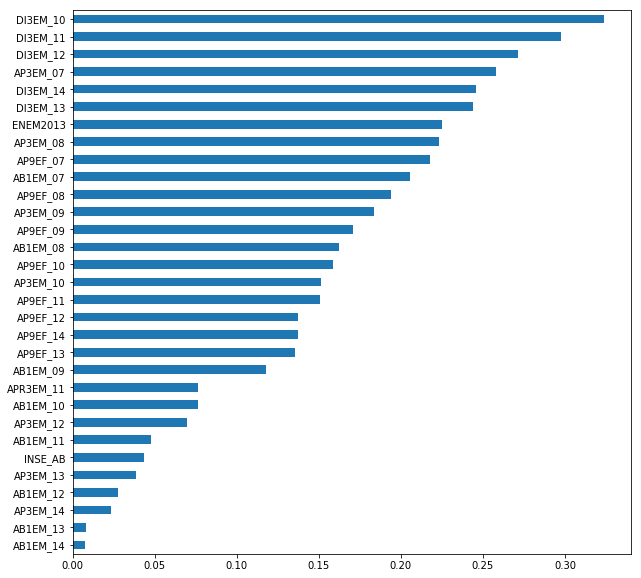

In [20]:
esc_rmsp.loc[:,esc_rmsp.isna().mean().sort_values(ascending = False) != 0].isna().mean().sort_values().plot(kind = "barh", figsize = (10,10))

In [24]:
esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isna().mean() > 0.23], axis = 1, inplace = True)

In [25]:
esc_rmsp.shape

(1241, 57)

In [43]:
esc_rmsp_limpo = esc_rmsp.dropna(how = 'any')
print(esc_rmsp_limpo.shape)

(632, 57)


In [44]:
esc_rmsp_limpo.dtypes

CODMEC         int64
ID             int64
LONGITUDE      int64
LATITUDE       int64
CODESCTX       int64
CODMUN         int64
COD_DEP        int64
CEP          float64
LOCALIZA       int64
LAB_INF        int64
QD_ESP_C       int64
QD_ESP_D       int64
BIBLIO         int64
ENS_REG        int64
REG_IN_PE      int64
REG_FU_8A      int64
REG_FU_9A      int64
REG_MED        int64
REG_MED_I      int64
REG_MED_N      int64
REG_MED_P      int64
ENS_ESP        int64
ESP_FU_8A      int64
ESP_MED        int64
ESP_MED_I      int64
ESP_MED_N      int64
ESP_MED_P      int64
ESP_EJA_F      int64
ESP_EJA_M      int64
EJA            int64
EJA_FUND       int64
EJA_PROJ       int64
AP9EF_07     float64
AB1EM_07     float64
AP9EF_08     float64
AP3EM_08     float64
AB1EM_08     float64
AP9EF_09     float64
AP3EM_09     float64
AB1EM_09     float64
AP9EF_10     float64
AP3EM_10     float64
AB1EM_10     float64
AP9EF_11     float64
APR3EM_11    float64
AB1EM_11     float64
AP9EF_12     float64
AP3EM_12     

In [51]:
for col in esc_rmsp_limpo.columns[esc_rmsp_limpo.dtypes != "float64"]:
    esc_rmsp_limpo[col].astype('float64')
print('Número de colunas que não são float64: ', sum(esc_rmsp_limpo.dtypes != "float64"))

Número de colunas que não são float64:  0


In [66]:
df = pd.merge(esc_rmsp_limpo, nota, on = "CODMEC")
scaler = StandardScaler()
data = scaler.fit_transform(df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES', 'Classificacao'], axis = 1))
x_train, x_test, y_train, y_test = train_test_split(data, df.Classificacao, test_size = 0.2)
lm = LinearRegression()
lm.fit(x_train, y_train)
print(lm.score(x_train, y_train), lm.score(x_test,y_test))

0.6469915121791048 -3.5269851254245485e+17


In [77]:
df = pd.merge(esc_rmsp_limpo, nota, on = "CODMEC")
scaler = StandardScaler()
pca = PCA(0.95)
data = scaler.fit_transform(df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES', 'Classificacao'], axis = 1))
data = pca.fit_transform(data)
x_train, x_test, y_train, y_test = train_test_split(data, df.Classificacao, test_size = 0.2)
lm = LinearRegression()
lm.fit(x_train, y_train)
print(lm.score(x_train, y_train), lm.score(x_test,y_test))

0.6102342905374817 0.1542486776439778


## teste com as médias

In [31]:
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
#DROPANDO ALGUMAS COLUNAS
cols = ['ID', 'LONGITUDE', 'LATITUDE', 'CODESCTX', 'CODMUN', 'CODDIST', 'COD_SC','CEP']
cols_reg = ['ENS_REG', 'REG_IN_CR', 'REG_IN_PE', 'REG_FU_8A', 'REG_FU_9A',
            'REG_MED', 'REG_MED_I', 'REG_MED_N', 'REG_MED_P']
cols_esp = ['ENS_ESP', 'ESP_IN_CR', 'ESP_IN_PE', 'ESP_FU_8A', 'ESP_FU_9A',
            'ESP_MED', 'ESP_MED_I', 'ESP_MED_N', 'ESP_MED_P']
cols_eja = ['ESP_EJA_F', 'ESP_EJA_M', 'EJA', 'EJA_FUND', 'EJA_MED', 'EJA_PROJ']
cols_aprov = ['AP5EF_07', 'AP9EF_07', 'AP3EM_07', 'AP5EF_08' , 'AP9EF_08', 'AP3EM_08',
             'AP5EF_09', 'AP9EF_09', 'AP3EM_09', 'AP5EF_10', 'AP9EF_10', 'AP3EM_10',
             'AP5EF_11', 'AP9EF_11', 'APR3EM_11', 'AP5EF_12', 'AP9EF_12', 'AP3EM_12',
             'AP5EF_13', 'AP9EF_13', 'AP3EM_13', 'AP5EF_14', 'AP9EF_14', 'AP3EM_14']
cols_aban = ['AB1EM_07', 'AB1EM_08', 'AB1EM_09', 'AB1EM_10', 'AB1EM_11', 'AB1EM_12', 'AB1EM_13', 'AB1EM_14']
cols_dist = ['DI3EM_07', 'DI3EM_08', 'DI3EM_09', 'DI3EM_10','DI3EM_11', 'DI3EM_12', 'DI3EM_13', 'DI3EM_14']
cols_pbras_inic = ['MAT05_AI', 'LP05_AI', 'NP05_AI', 'MAT07_AI', 'LP07_AI', 
            'NP07_AI','MAT09_AI', 'LP09_AI', 'NP09_AI', 'MAT11_AI', 'LP11_AI',
            'NP11_AI', 'MAT13_AI', 'LP13_AI', 'NP13_AI']
cols_ideb_inic = ['IDEB05AI', 'IDEB07AI', 'IDEB09AI', 'IDEB11AI', 'IDEB13AI']
cols_pbras_fin = ['MAT05_AF', 'LP05_AF', 'NP05_AF', 'MAT07_AF', 'LP07_AF', 
                   'NP07_AF', 'MAT09_AF', 'LP09_AF', 'NP09_AF', 'MAT11_AF', 
                   'LP11_AF', 'NP11_AF', 'MAT13_AF', 'LP13_AF', 'NP13_AF']
cols_ideb_fin = ['IDEB05AF', 'IDEB07AF', 'IDEB09AF', 'IDEB11AF', 'IDEB13AF']
cols_enem = ['RED_EN13', 'LC_EN13', 'MAT_EN13', 'CH_EN13', 'CN_EN13', 'ENEM2013']
cols_inse = ['INSE_AB']
esc_rmsp.drop(cols, axis = 1, inplace = True)

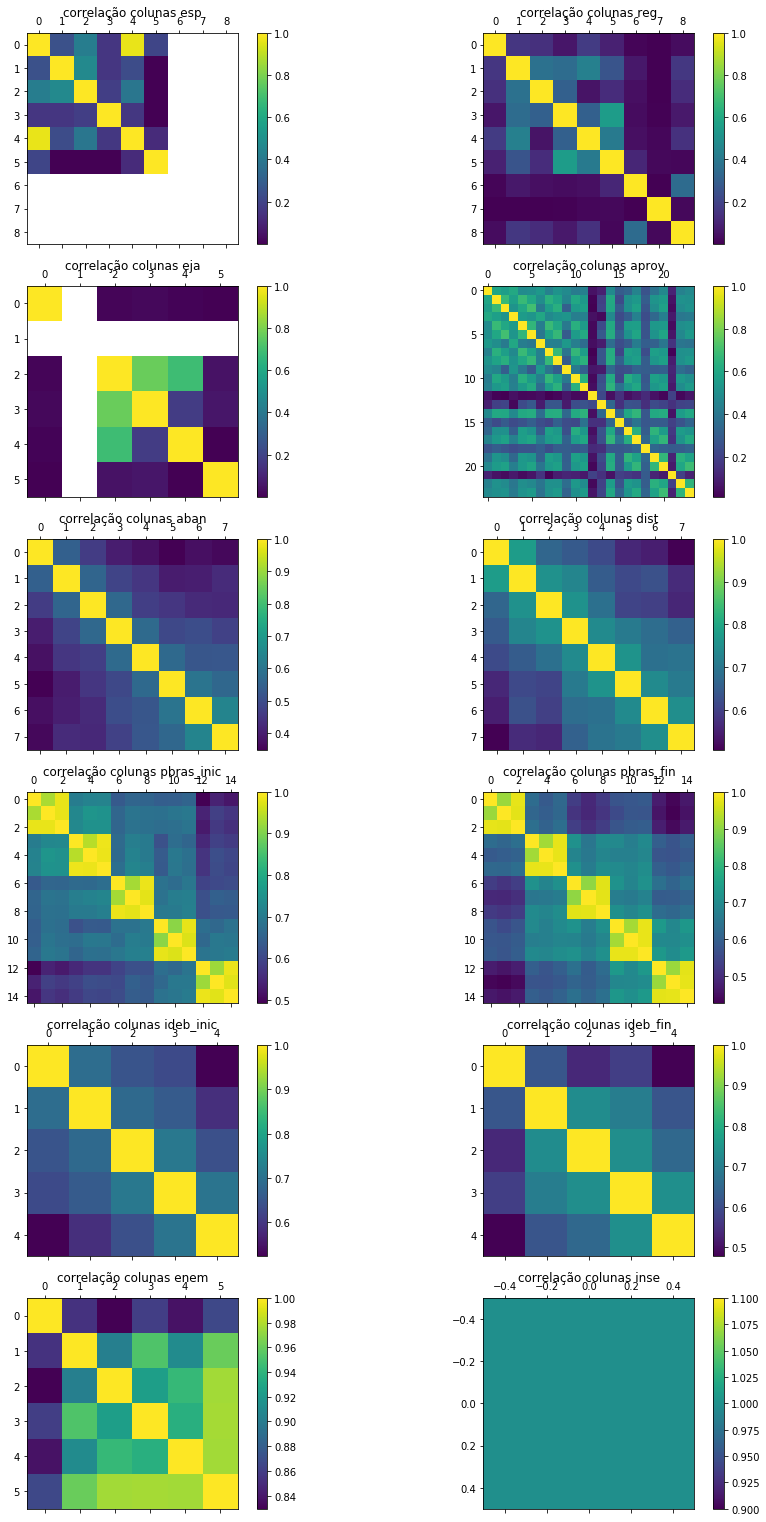

In [32]:
plt.figure(figsize = (15,20))

plt.subplots_adjust(top = 1.15)
#colunas esp
plt.subplot(6,2,1)
plt.matshow(esc_rmsp[cols_esp].corr().abs(),0)
plt.title('correlação colunas esp')
plt.colorbar()


#colunas reg
plt.subplot(6,2,2)
plt.matshow(esc_rmsp[cols_reg].corr().abs(),0)
plt.title('correlação colunas reg')
plt.colorbar()

#colunas eja
plt.subplot(6,2,3)
plt.matshow(esc_rmsp[cols_eja].corr().abs(),0)
plt.title('correlação colunas eja')
plt.colorbar()

#colunas aprov
plt.subplot(6,2,4)
plt.matshow(esc_rmsp[cols_aprov].corr().abs(),0)
plt.title('correlação colunas aprov')
plt.colorbar()

#colunas aban
plt.subplot(6,2,5)
plt.matshow(esc_rmsp[cols_aban].corr().abs(),0)
plt.title('correlação colunas aban')
plt.colorbar()

#colunas dist
plt.subplot(6,2,6)
plt.matshow(esc_rmsp[cols_dist].corr().abs(),0)
plt.title('correlação colunas dist')
plt.colorbar()

#colunas pbras_inic
plt.subplot(6,2,7)
plt.matshow(esc_rmsp[cols_pbras_inic].corr().abs(), 0)
plt.title('correlação colunas pbras_inic')
plt.colorbar()

#colunas pbras_fin
plt.subplot(6,2,8)
plt.matshow(esc_rmsp[cols_pbras_fin].corr().abs(),0)
plt.title('correlação colunas pbras_fin')
plt.colorbar()

#colunas ideb_inic
plt.subplot(6,2,9)
plt.matshow(esc_rmsp[cols_ideb_inic].corr().abs(),0)
plt.title('correlação colunas ideb_inic')
plt.colorbar()

#colunas ideb_fin
plt.subplot(6,2,10)
plt.matshow(esc_rmsp[cols_ideb_fin].corr().abs(),0)
plt.title('correlação colunas ideb_fin')
plt.colorbar()

#colunas enem
plt.subplot(6,2,11)
plt.matshow(esc_rmsp[cols_enem].corr().abs(),0)
plt.title('correlação colunas enem')
plt.colorbar()

#colunas inse
plt.subplot(6,2,12)
plt.matshow(esc_rmsp[cols_inse].corr().abs(), 0)
plt.title('correlação colunas inse')
plt.colorbar()

plt.show()

## teste utilizando a média de algumas colunas

In [33]:
cols_reg.remove('ENS_REG')
cols_esp.remove('ENS_ESP')
cols_eja.remove('EJA')
cols_enem.remove('ENEM2013')
media_esc_rmsp = esc_rmsp.drop(cols_reg + cols_esp + cols_eja + cols_enem, axis =1)

In [34]:
cols_pbras = ['NP05_AI', 'NP07_AI', 'NP09_AI', 'NP11_AI', 'NP13_AI', 
              'NP05_AF', 'NP07_AF', 'NP09_AF', 'NP11_AF', 'NP13_AF']
media_esc_rmsp['MEDIA_APROV'] = media_esc_rmsp[cols_aprov].mean(axis = 1)
media_esc_rmsp['MEDIA_ABAN'] = media_esc_rmsp[cols_aban].mean(axis = 1)
media_esc_rmsp['MEDIA_DIST'] = media_esc_rmsp[cols_dist].mean(axis = 1)
media_esc_rmsp['MEDIA_IDEB'] = media_esc_rmsp[cols_ideb_fin + cols_ideb_inic].mean(axis = 1)
media_esc_rmsp['MEDIA_PBRAS'] = media_esc_rmsp[cols_pbras].mean(axis = 1)
media_esc_rmsp.drop(cols_aprov + cols_aban + cols_dist + cols_ideb_fin + cols_ideb_inic + cols_pbras_inic + cols_pbras_fin , axis = 1, inplace = True)
media_esc_rmsp.head()

,COD_DEP,LOCALIZA,LAB_INF,QD_ESP_C,QD_ESP_D,BIBLIO,ENS_REG,ENS_ESP,EJA,ENEM2013,INSE_AB,MEDIA_APROV,MEDIA_ABAN,MEDIA_DIST,MEDIA_IDEB,MEDIA_PBRAS
CODESC,,,,,,,,,,,,,,,,
35000012,2,1,1,1,1,1,1,0,0,NaN,55.3166,83.635714,1.566667,14.816667,4.350000,4.750000
35000024,2,1,1,1,1,0,1,0,1,NaN,51.8084,83.665000,7.400000,26.925000,4.116667,4.745000
35000036,2,1,1,1,0,1,1,0,0,NaN,52.9689,86.562500,4.862500,18.425000,3.975000,4.260000
35000048,2,1,1,1,0,1,1,0,0,NaN,51.4838,84.935294,8.025000,22.825000,3.560000,4.276000
35000059,2,1,1,1,0,0,1,0,0,NaN,50.4455,85.838462,7.550000,20.787500,4.166667,4.583333


In [35]:
print('Tamanho do dataframe: ', media_esc_rmsp.shape)
media_esc_rmsp = media_esc_rmsp.reset_index()[media_esc_rmsp.reset_index().CODESC.isin(nota['CODMEC'])]
media_esc_rmsp = media_esc_rmsp.reset_index()
media_esc_rmsp.rename(columns = {'CODESC':'CODMEC'}, inplace = True)
media_esc_rmsp.isna().mean().sort_values()

Tamanho do dataframe:  (10937, 16)


index          0.000000
EJA            0.000000
ENS_ESP        0.000000
BIBLIO         0.000000
QD_ESP_D       0.000000
ENS_REG        0.000000
LAB_INF        0.000000
LOCALIZA       0.000000
COD_DEP        0.000000
CODMEC         0.000000
QD_ESP_C       0.000000
MEDIA_APROV    0.001612
MEDIA_ABAN     0.003223
MEDIA_DIST     0.041902
INSE_AB        0.043513
ENEM2013       0.224819
MEDIA_IDEB     0.716358
MEDIA_PBRAS    0.716358
dtype: float64

In [ ]:
media_esc_rmsp.drop(['MEDIA_IDEB', 'MEDIA_PBRAS'], axis = 1, inplace = True)

In [80]:
media_esc_rmsp.dropna(how = 'any', inplace = True)
novo_df = pd.merge(media_esc_rmsp, nota, on = 'CODMEC')
data = novo_df.drop(['NUMERO DE PARTICIPANTES', 'Classificacao', 'CODMEC', 'index', 'LOCALIZA', 'QD_ESP_C', 'QD_ESP_D'], axis = 1)
target = novo_df.Classificacao
colunas = data.columns

In [84]:
for col in data.columns[data.dtypes == 'int64']:
    data[col] = data[col].astype('float64')

In [76]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
lm = LinearRegression()
lm.fit(x_train, y_train)
previsoes = lm.predict(data)
col_values = list(zip(lm.coef_, colunas))
print(lm.score(x_train, y_train), lm.score(x_test, y_test))

0.644906223136382 0.5767915245022794


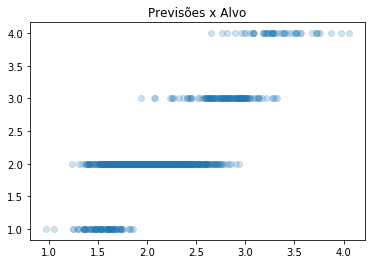

In [77]:
plt.scatter(previsoes, target, alpha = 0.2)
plt.title('Previsões x Alvo')
plt.show()

In [65]:
col_values = [(abs(a), b) for (a,b) in col_values]
col_values.sort(reverse = True)
col_values

[(0.46708526554578256, 'ENEM2013'),
 (0.09195981077198187, 'INSE_AB'),
 (0.07116825059857414, 'MEDIA_APROV'),
 (0.06907919034076261, 'MEDIA_DIST'),
 (0.05531249352653578, 'MEDIA_ABAN'),
 (0.017440246876755022, 'EJA'),
 (0.011317831466958991, 'ENS_ESP'),
 (0.009361222248606004, 'COD_DEP'),
 (0.004836584348454853, 'BIBLIO'),
 (0.0029290063714866358, 'LAB_INF'),
 (5.551115123125783e-17, 'ENS_REG')]

In [78]:
def modelo_svm_kf(data, target, gamma, C, k):
    kf = KFold(n_splits = k)
    scores = []
    for g in gamma:
            for c in C:
                mean_kf = []
                for train_i, test_i in kf.split(data):
                    #separação dos dados em treino e teste
                    data_train, data_test = data.iloc[train_i], data.iloc[test_i]
                    target_train, target_test = target[train_i], target[test_i]
                    
                    #normalização dos dados
                    scaler = StandardScaler()
                    scaler.fit(data_train)
                    data_train = scaler.transform(data_train)
                    data_test = scaler.transform(data_test)
                    
                    #pca nos dados
                    pca = PCA(0.95)
                    pca.fit(data_train)
                    data_train = pca.transform(data_train)
                    data_test = pca.transform(data_test)
                    
                    #rodando o svm
                    svc = SVC(kernel = 'rbf', C=c, gamma = g)
                    svc.fit(data_train,target_train)
                    mean_kf.append(svc.score(data_test,target_test))
                                   
                #salvando a média do KFold para g e c dados
                scores.append(((sum(mean_kf)/len(mean_kf)), g, c))
                print('Iteração com gamma %f e c %f concluída' %(g, c))
    return scores

In [85]:
res = modelo_svm_kf(data, target, gamma = [0.01, 0.1, 1, 10, 100], C = [0.01, 0.1, 1, 10, 100], k = 5)
res.sort()
print('Maiores score e os parâmetros:')
res[-5:]

Iteração com gamma 0.010000 e c 0.010000 concluída
Iteração com gamma 0.010000 e c 0.100000 concluída
Iteração com gamma 0.010000 e c 1.000000 concluída
Iteração com gamma 0.010000 e c 10.000000 concluída
Iteração com gamma 0.010000 e c 100.000000 concluída
Iteração com gamma 0.100000 e c 0.010000 concluída
Iteração com gamma 0.100000 e c 0.100000 concluída
Iteração com gamma 0.100000 e c 1.000000 concluída
Iteração com gamma 0.100000 e c 10.000000 concluída
Iteração com gamma 0.100000 e c 100.000000 concluída
Iteração com gamma 1.000000 e c 0.010000 concluída
Iteração com gamma 1.000000 e c 0.100000 concluída
Iteração com gamma 1.000000 e c 1.000000 concluída
Iteração com gamma 1.000000 e c 10.000000 concluída
Iteração com gamma 1.000000 e c 100.000000 concluída
Iteração com gamma 10.000000 e c 0.010000 concluída
Iteração com gamma 10.000000 e c 0.100000 concluída
Iteração com gamma 10.000000 e c 1.000000 concluída
Iteração com gamma 10.000000 e c 10.000000 concluída
Iteração com gamm

[(0.8068541199470991, 0.1, 100),
 (0.8122189638318671, 0.1, 1),
 (0.8154332700822264, 0.01, 10),
 (0.8154562704847335, 0.1, 10),
 (0.8186820769363464, 0.01, 100)]

In [86]:
res = modelo_svm_kf(data, target, gamma = [0.01, 0.1], C = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100], k = 5)
res.sort()
print('Maiores score e os parâmetros:')
res[-5:]

Iteração com gamma 0.010000 e c 0.010000 concluída
Iteração com gamma 0.010000 e c 0.050000 concluída
Iteração com gamma 0.010000 e c 0.100000 concluída
Iteração com gamma 0.010000 e c 0.500000 concluída
Iteração com gamma 0.010000 e c 1.000000 concluída
Iteração com gamma 0.010000 e c 5.000000 concluída
Iteração com gamma 0.010000 e c 10.000000 concluída
Iteração com gamma 0.010000 e c 50.000000 concluída
Iteração com gamma 0.010000 e c 100.000000 concluída
Iteração com gamma 0.100000 e c 0.010000 concluída
Iteração com gamma 0.100000 e c 0.050000 concluída
Iteração com gamma 0.100000 e c 0.100000 concluída
Iteração com gamma 0.100000 e c 0.500000 concluída
Iteração com gamma 0.100000 e c 1.000000 concluída
Iteração com gamma 0.100000 e c 5.000000 concluída
Iteração com gamma 0.100000 e c 10.000000 concluída
Iteração com gamma 0.100000 e c 50.000000 concluída
Iteração com gamma 0.100000 e c 100.000000 concluída
Maiores score e os parâmetros:


[(0.8154332700822264, 0.01, 10),
 (0.8154562704847335, 0.1, 10),
 (0.8175895578172618, 0.1, 5),
 (0.8186820769363464, 0.01, 100),
 (0.824029670519234, 0.01, 50)]

In [87]:
res = modelo_svm_kf(data, target, gamma = [0.01, 0.1], C = [10, 25, 33, 50, 66, 75, 100], k = 5)
res.sort()
print('Maiores score e os parâmetros:')
res[-5:]

Iteração com gamma 0.010000 e c 10.000000 concluída
Iteração com gamma 0.010000 e c 25.000000 concluída
Iteração com gamma 0.010000 e c 33.000000 concluída
Iteração com gamma 0.010000 e c 50.000000 concluída
Iteração com gamma 0.010000 e c 66.000000 concluída
Iteração com gamma 0.010000 e c 75.000000 concluída
Iteração com gamma 0.010000 e c 100.000000 concluída
Iteração com gamma 0.100000 e c 10.000000 concluída
Iteração com gamma 0.100000 e c 25.000000 concluída
Iteração com gamma 0.100000 e c 33.000000 concluída
Iteração com gamma 0.100000 e c 50.000000 concluída
Iteração com gamma 0.100000 e c 66.000000 concluída
Iteração com gamma 0.100000 e c 75.000000 concluída
Iteração com gamma 0.100000 e c 100.000000 concluída
Maiores score e os parâmetros:


[(0.8186820769363464, 0.01, 100),
 (0.8229544017020298, 0.01, 33),
 (0.824029670519234, 0.01, 50),
 (0.8240354206198608, 0.01, 66),
 (0.8240354206198608, 0.01, 75)]

In [88]:
res = modelo_svm_kf(data, target, gamma = [0.01], C = list(range(50, 90)), k = 5)
res.sort()
print('Maiores score e os parâmetros:')
res[-5:]

Iteração com gamma 0.010000 e c 50.000000 concluída
Iteração com gamma 0.010000 e c 51.000000 concluída
Iteração com gamma 0.010000 e c 52.000000 concluída
Iteração com gamma 0.010000 e c 53.000000 concluída
Iteração com gamma 0.010000 e c 54.000000 concluída
Iteração com gamma 0.010000 e c 55.000000 concluída
Iteração com gamma 0.010000 e c 56.000000 concluída
Iteração com gamma 0.010000 e c 57.000000 concluída
Iteração com gamma 0.010000 e c 58.000000 concluída
Iteração com gamma 0.010000 e c 59.000000 concluída
Iteração com gamma 0.010000 e c 60.000000 concluída
Iteração com gamma 0.010000 e c 61.000000 concluída
Iteração com gamma 0.010000 e c 62.000000 concluída
Iteração com gamma 0.010000 e c 63.000000 concluída
Iteração com gamma 0.010000 e c 64.000000 concluída
Iteração com gamma 0.010000 e c 65.000000 concluída
Iteração com gamma 0.010000 e c 66.000000 concluída
Iteração com gamma 0.010000 e c 67.000000 concluída
Iteração com gamma 0.010000 e c 68.000000 concluída
Iteração com

[(0.8261744580530159, 0.01, 70),
 (0.8261744580530159, 0.01, 71),
 (0.8261744580530159, 0.01, 72),
 (0.8261744580530159, 0.01, 74),
 (0.8272497268702204, 0.01, 73)]

### ridge regression

In [54]:
def ridge_aplicada1(df, alphas):
    
    #criando o merge do data e do target
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    
    #inicializando variáveis do tuning
    coefs = []
    score = []
    best_score = 0
    n_features = len(data.columns)
    
    #normalizando os dados
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    #fazendo o tuning do alpha
    for val in alphas:
        
        #separando em treino e teste
        ridge = Ridge(alpha = val)
        ridge.fit(data, target) #treinamento nos dados
        score.append(ridge.score(data, target))
        coefs.append(ridge.coef_)
    
    features_values = list(zip(ridge.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do Ridge')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de Ridge')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)
    print("melhor score: ", best_score)

In [55]:
def ridge_aplicada2(df, alphas):
    
    #criando o merge do data e do target
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    
    #inicializando variáveis do tuning
    coefs = []
    score = []
    best_score = 0
    n_features = len(data.columns)
    
    #normalizando os dados
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    #fazendo o tuning do alpha
    for val in alphas:
        
        #separando em treino e teste
        x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
        ridge = Ridge(alpha = val)
        ridge.fit(x_train, y_train) #treinamento nos dados
        score.append(ridge.score(x_test, y_test))
        coefs.append(ridge.coef_)
    
    features_values = list(zip(ridge.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do Ridge')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de Ridge')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)
    print("melhor score: ", best_score)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


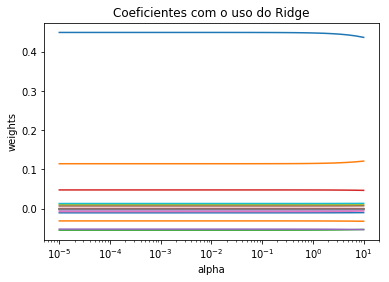

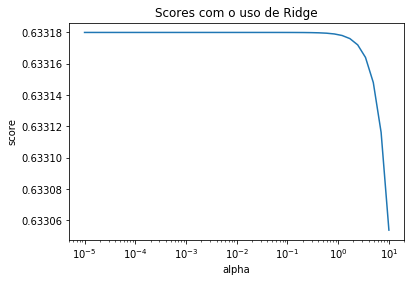

nº colunas:  2
[(0.4363437032129553, 'ENEM2013'), (0.12127993881005099, 'INSE_AB')]
melhor score:  0


In [56]:
n_alphas = 40
alphas = np.logspace(-5, 1, n_alphas)
ridge_aplicada1(media_esc_rmsp, alphas)

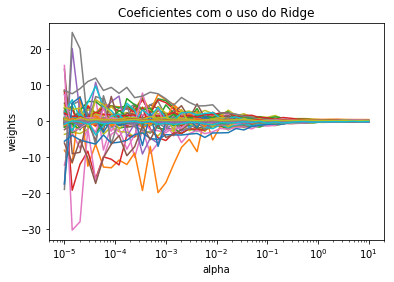

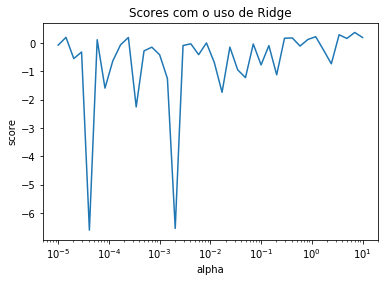

nº colunas:  6
[(0.42895029590433353, 'Qtde_Docentes'), (0.2450177488024711, 'NUM_FUNC'), (0.19869238566811223, 'ALE9F9S'), (0.15063697716267382, '6fund'), (0.11185007618600391, 'ALEDESP'), (0.111488657133578, 'CLE9F1S')]
melhor score:  0


In [10]:
ridge_aplicada2(dados_escolares, alphas)

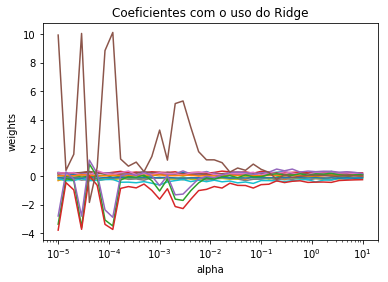

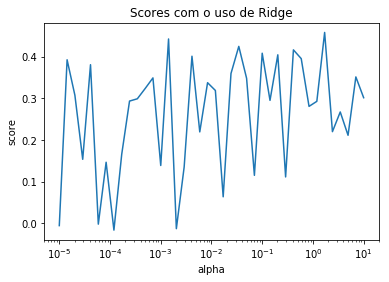

nº colunas:  6
[(0.23616769223092096, 'EFAPROV9ANOS4S'), (0.1936828873450141, 'EMAPROV3S'), (0.1557591133127169, 'EFAPROV9ANOS7S'), (0.11749418890992476, 'EFAPROV9ANOS1S'), (0.11490219062627978, 'EMAPROV1S'), (0.10173109901577652, 'EFAPROV9ANOS6S')]
melhor score:  0


In [6]:
ridge_aplicada(rendimento, alphas)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


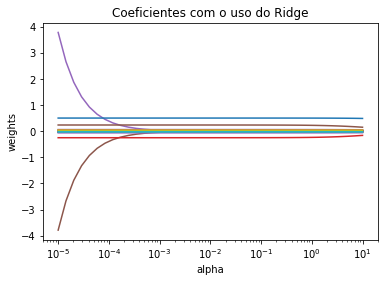

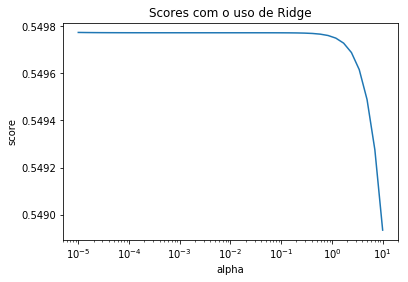

nº colunas:  2
[(0.48870425647490523, 'INSE_AB'), (0.1520988081183864, 'EJA_MED')]
melhor score:  0


In [18]:
ridge_aplicada1(esc_rmsp, alphas)

In [20]:
esc_rmsp.shape

(931, 52)

In [26]:
def lasso_aplicada(df, alphas):
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    coefs = []
    score = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    for val in alphas:
        lasso = Lasso(alpha = val, tol = 0.001)
        lasso.fit(data, target)
        coefs.append(lasso.coef_)
        score.append(lasso.score(data,target))
    
    features_values = list(zip(lasso.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do lasso')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de lasso')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


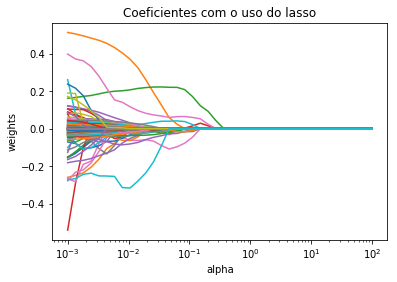

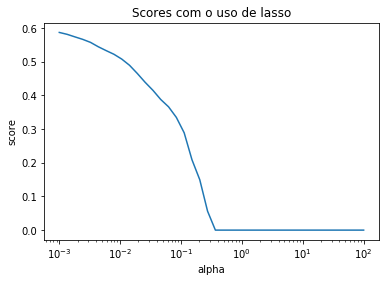

nº colunas:  0
[]


In [27]:
n_alphas = 40
alphas = np.logspace(-3, 2, n_alphas)
lasso_aplicada(dados_escolares, alphas)

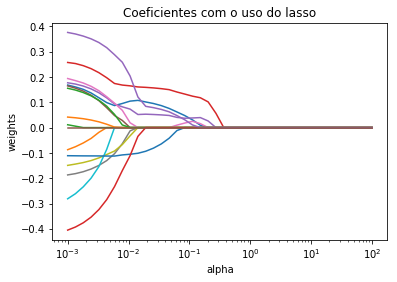

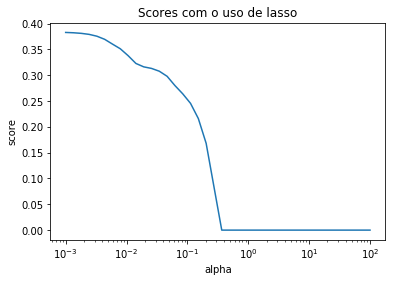

nº colunas:  0
[]


In [28]:
lasso_aplicada(rendimento, alphas)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


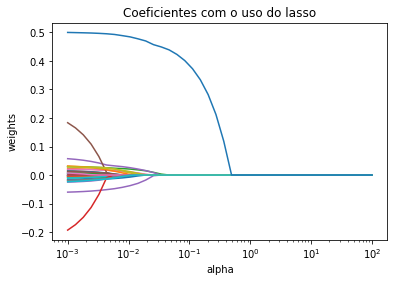

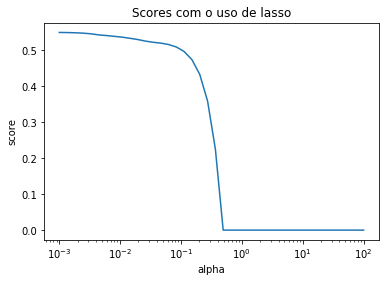

nº colunas:  0
[]


In [29]:
lasso_aplicada(esc_rmsp, alphas)